In [5]:
from thymiodirect import Thymio, Connection
import time
import math
from math import cos, sin
from ThymioUtils import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
port = Connection.serial_default_port()

In [3]:
# Connect to Thymio and store id in variable

th = Thymio(serial_port = port, on_connect = lambda id: print (f"{id} is connected"))
th.connect()
id_thymio = th.first_node()

34241 is connected


In [4]:
th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0
th[id_thymio]["leds.top"] = [0, 0, 0]

## Exercise 8

In [30]:
def x(t):
    return 20*t

def y(t):
    return 0.8*((t-20)**2)+100

def c(t):
    x_coord = x(t)
    y_coord = y(t)
    return np.array([x_coord, y_coord])

def c1(t):
    h = 1E-8
    return (c(t+h)-c(t))/h

def c1_left(t):
    h = 0.01
    return (get_left_wheel(t+h)-get_left_wheel(t))/h

def c1_right(t):
    h = 0.01
    return (get_right_wheel(t+h)-get_right_wheel(t))/h

def rotate_vec_90(v):
    theta = np.deg2rad(90)

    rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    return np.dot(rot, v)

def rotate_vec_270(v):
    theta = np.deg2rad(270)

    rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    return np.dot(rot, v)

def get_left_wheel(t):
    x_value, y_value = c(t)
    x_left, y_left = rotate_vec_90(c1(t)/np.linalg.norm(c1(t)) * 48)
    return np.array([x_value + x_left, y_value + y_left])


def get_right_wheel(t):
    x_value, y_value = c(t)
    x_right, y_right = rotate_vec_270(c1(t)/np.linalg.norm(c1(t)) * 48)
    return np.array([x_value + x_right, y_value + y_right])

In [31]:
def plot_tangents(times, ax):
    for time in times:
        s1 = c(time)
        p1 = c1(time)
        ax.arrow(s1[0], s1[1], p1[0]*5, p1[1]*5)
        
def plot_tangents_left(times, ax):
    for time in times:
        s1 = get_left_wheel(time)
        p1 = c1_left(time)
        ax.arrow(s1[0], s1[1], p1[0]*5, p1[1]*5)

def plot_tangents_right(times, ax):
    for time in times:
        s1 = get_right_wheel(time)
        p1 = c1_right(time)
        ax.arrow(s1[0], s1[1], p1[0]*5, p1[1]*5)
        
def plot_tangents_rotated(times, ax):
    for time in times:
        s1 = c(time)
        p1 = rotate_vec_90(c1(time)/np.linalg.norm(c1(time)) * 48)
        p2 = rotate_vec_270(c1(time)/np.linalg.norm(c1(time)) * 48)
        ax.arrow(s1[0], s1[1], p1[0], p1[1])
        ax.arrow(s1[0], s1[1], p2[0], p2[1])

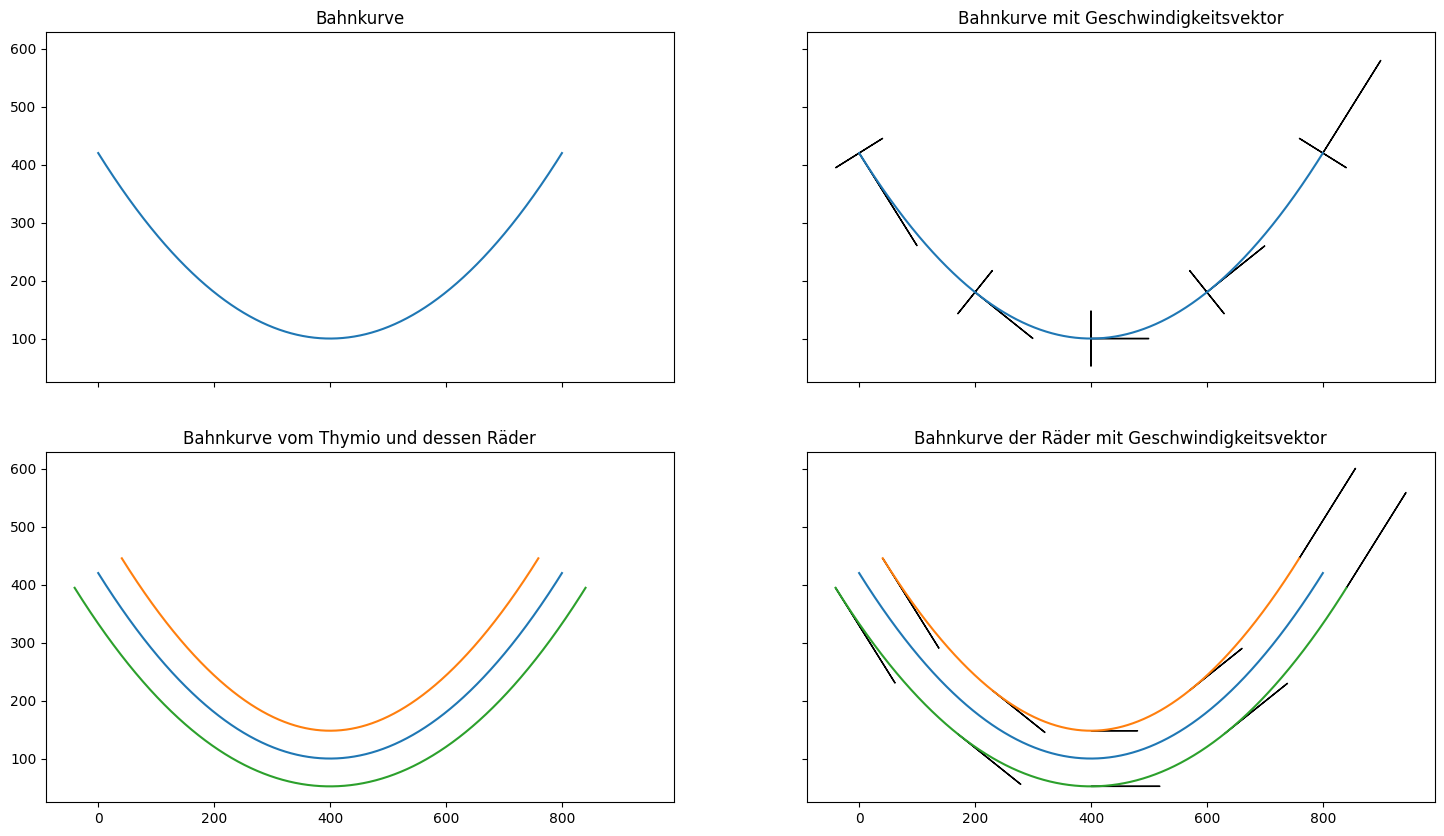

In [51]:
x_values = []
y_values = []
x_lefts = []
y_lefts = []
x_rights = []
y_rights = []

for i in range(2001):
    t = i/50
    x_value, y_value = c(t)
    x_values.append(x_value)
    y_values.append(y_value)
    x_left, y_left = get_left_wheel(t)
    x_right, y_right = get_right_wheel(t)
    x_values.append(x_value)
    y_values.append(y_value)
    x_lefts.append(x_left)
    y_lefts.append(y_left)
    x_rights.append(x_right)
    y_rights.append(y_right)
    
fig, axs = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)
axs[0, 0].set(adjustable='box', aspect='equal')
axs[0, 1].set(adjustable='box', aspect='equal')
axs[1, 0].set(adjustable='box', aspect='equal')
axs[1, 1].set(adjustable='box', aspect='equal')

axs[0, 0].title.set_text('Bahnkurve')
axs[0, 1].title.set_text('Bahnkurve mit Geschwindigkeitsvektor')
axs[1, 0].title.set_text('Bahnkurve vom Thymio und dessen Räder')
axs[1, 1].title.set_text('Bahnkurve der Räder mit Geschwindigkeitsvektor')
    
axs[0, 0].plot(x_values, y_values)
axs[0, 1].plot(x_values, y_values)
axs[1, 0].plot(x_values, y_values)
axs[1, 1].plot(x_values, y_values)
axs[1, 0].plot(x_lefts, y_lefts)
axs[1, 0].plot(x_rights, y_rights)
axs[1, 1].plot(x_lefts, y_lefts)
axs[1, 1].plot(x_rights, y_rights)
plot_tangents([0, 10, 20, 30, 40], axs[0, 1])
plot_tangents_rotated([0, 10, 20, 30, 40], axs[0, 1])
plot_tangents_left([0, 10, 20, 30, 40], axs[1, 1])
plot_tangents_right([0, 10, 20, 30, 40], axs[1, 1])

In [43]:
times = []
left_speeds = []
right_speeds = []

for i in range(400):
    t = i/10
    times.append(t)
    left_speeds.append(mms_to_thymio(np.linalg.norm(c1_left(t))))
    right_speeds.append(mms_to_thymio(np.linalg.norm(c1_right(t))))

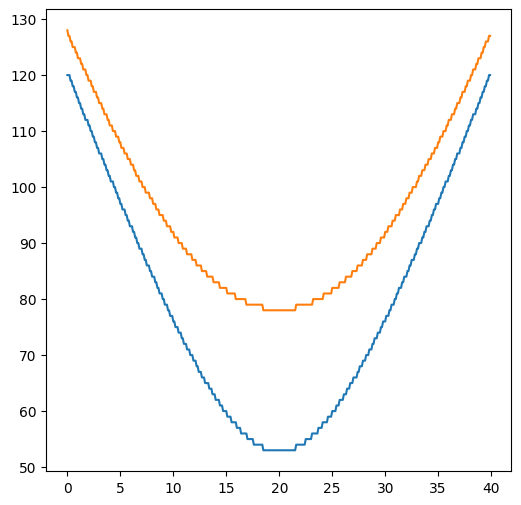

In [54]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(times, left_speeds)
ax.plot(times, right_speeds)

plt.show()

In [11]:
for speed in zip(left_speeds, right_speeds):
    th[id_thymio]["motor.left.target"] = speed[0]
    th[id_thymio]["motor.right.target"] = speed[1]
    time.sleep(0.1)
    
th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0